<a href="https://colab.research.google.com/github/xiaojieTao/UCLA-ECE209AS-2022F/blob/main/gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np

In [19]:
import matplotlib.pyplot as plt
def print_table(data):
    value_table = data.reshape((5,5))
    value_table = np.around(value_table,1)
    fig, ax = plt.subplots()
    # Plot the heatmap.
    im = ax.imshow(value_table, interpolation="nearest")

    # Create colorbar.
    fig.colorbar(im, ax=ax)

    # Loop over data dimensions and create text annotations.
    for i in range(5):
        for j in range(5):
            text = ax.text(j, i, value_table[i, j],
                        ha="center", va="center", color="w")

    ax.set_title("State-value heatmap:")
    plt.show()

Now start running the cells sequentially (by `ctrl + enter` or `shift + enter`) to avoid unnecessary errors by skipping some cells. 

## Section 1: Westwood Gridworld Environment

In this section, we build the Westwood Gridworld environment, with which we can solve using MDP in Section 2.

Every Westwood Gridworld environment should contain the following attributes:

1. `env.action_space`
2. `env.observation_space`
3. `env.P` The transition probabilities matrix. 

In [20]:
# Action Space
# - 0: LEFT
# - 1: DOWN
# - 2: RIGHT
# - 3: UP
# - 4: WAIT
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
WAIT = 4

# Define WestwoodGridworld class.
class WestwoodGridworld:
    def __init__(self):
        # Row and column size of the gridworld.
        self.nrow = 5
        self.ncol = 5

        # Size of the action space and state space.
        self.nA = 5
        self.nS = self.nrow * self.ncol

        # desc represents the map of the WestwoodGridworld.
        # Row 0 through row 4.
        self.desc=["PPPPW", "PBBPW", "PPDPW", "PBBPW","PPSPW"]
        self.desc = np.asarray(self.desc, dtype="c")

        # Letter represents the nature of each state.
        # 'D' = Diddy-Riese state
        # 'S' = Saffron-Rose state
        # 'W' = Westwood Boulevard state
        # 'B' = Obstacle state
        # 'P' = Pavement state


        # Assign reward to each state.
        self.rewardOfStates = {
            b"D": 1.0,
            b"S": 10.0,
            b"W": -10.0,
            b"B": 0,
            b"P": 0
        }

        # pe: probability of noisy transition.
        self.pe = 0.2

        # P is the transition probabilities of each pair of state and action.
        # For each pair of state and action, P[state][action] is a list of transitions,
        # each transition is a list consists of prob, next_state, and reward.
        self.P = {state: {action: [] for action in range(self.nA)} for state in range(self.nS)}

        # Initialize the transition probabilities matrix P.
        self.computeP()

    # Compute the transition probabilities matrix P.        
    def computeP(self):
        for row in range(self.nrow):
            for col in range (self.ncol):

                # When the robot chooses to move, it has a chance of error pe.
                s = self.to_s(row, col)

                for a in range(4):
                    li = self.P[s][a]
                    dynamics = self.update_probability_matrix(row, col, a)
                    
                    # Append a list with prob, next_state, and reward.
                    li.append(
                        ((1-self.pe) * dynamics[0], dynamics[1], dynamics[2])
                    )
                    for b in [(a-1)%4, (a+1)%4, (a+2)%4, 4]:
                        dynamics = self.update_probability_matrix(row, col, b)
                        li.append(
                        ((self.pe/4) * dynamics[0], dynamics[1], dynamics[2])
                    )
                        
                # When the robot chooses to wait (the last action), it always end up waiting.
                li = self.P[s][4]
                dynamics = self.update_probability_matrix(row, col, 4)
                li.append(
                    (dynamics[0], dynamics[1], dynamics[2])
                )

    def to_s(self, row, col):
        return row * self.ncol + col

    def inc(self, row, col, a):
        if self.desc[row, col] == b'B':
            return (row, col)

        ROW = row
        COL = col

        if a == LEFT: 
            col = max(col - 1, 0)
        elif a == DOWN:
            row = min(row + 1, self.nrow - 1)
        elif a == RIGHT:
            col = min(col + 1, self.ncol - 1)
        elif a == UP:
            row = max(row - 1, 0)

        if self.desc[row, col] == b'B':
            row = ROW
            col = COL

        return (row, col)

    def update_probability_matrix(self, row, col, action):
        newrow, newcol = self.inc(row, col, action)
        newstate = self.to_s(newrow, newcol)
        letter = self.desc[row, col]
        newletter = self.desc[newrow, newcol]
        reward = self.rewardOfStates[letter]
        prob = 1.0

        return prob, newstate, reward

## Section 2: Compute Optimal Policy

In [21]:
class TabularRLTrainerAbstract:
    """This is the abstract class for tabular RL trainer. We will inherent the specify 
    algorithm's trainer from this abstract class, so that we can reuse the codes like
    getting the dynamic of the environment (self._get_transitions()) """
    def __init__(self):
        self.env = WestwoodGridworld()
        self.action_dim = 5
        self.obs_dim = 25

    def _get_transitions(self, state, act):
        """Query the environment to get the transition probability, 
        the next state, and reward given a pair of state and action.
        """
        transitions = self.env.P[state][act]
        ret = []
        for prob, next_state, reward in transitions:
            ret.append({
                "prob": prob,
                "next_state": next_state,
                "reward": reward
            })
        return ret

    def print_table(self):
        """print beautiful table, only work for Ice Cream Gridworld"""
        print_table(self.table)

    def train(self):
        """Conduct one iteration of learning."""
        raise NotImplementedError("You need to override the "
                                    "Trainer.train() function.")

### Section 2.1: Policy Iteration

Recall the process of policy iteration: 

1. Update the state value function, given all possible transitions at current state of the environment.
2. Find the best policy that earns highest value under current state value function.
3. If the best policy is identical to the previous one then stop the training. Otherwise, return to step 1.

In step 1, the way to update the state value function is by 

$$v_{k+1} = E_{s'}[r(s, a)+\gamma v_{k}(s')]$$

wherein the $a$ is given by current policy, $s'$ is next state, $r$ is the reward, $v_{k}(s')$ is the next state value given by the old (not updated yet) value function. The expectation is computed among all possible transitions (given a state and action pair, it is possible to have many different next states, since the environment is not deterministic).

In step 2, the best policy is the one that takes the action with maximal expected return given a state:

$$a = {argmax}_a E_{s'}[r(s, a) + \gamma v_{k}(s')]$$

Policy iteration algorithm has an outer loop (update policy, step 1 to 3) and an inner loop (fit the value function, within step 1). 

In each outer loop, we call once `trainer.train()`, where we call `trainer.update_value_function()` once to update the value function (the state value table). 

After that we call `trainer.update_policy()` to update the current policy. 

`trainer` object has a `trainer.policy` attribute, which is a function that takes observation as input and returns an action.

In [22]:
class PolicyItertaionTrainer(TabularRLTrainerAbstract):
    def __init__(self, gamma=1.0, eps=1e-10):
        super(PolicyItertaionTrainer, self).__init__()
        # discount factor
        self.gamma = gamma

        # value function convergence criterion
        self.eps = eps

        # build the value table for each possible observation
        self.table = np.zeros((self.obs_dim,))

        # A random policy at the beginning.
        self.policy = lambda x : 1

    def train(self):
        """Conduct one iteration of learning."""

        self.update_value_function()
        self.update_policy()

    def update_value_function(self):
        while True:
            old_table = self.table.copy()

            for state in range(self.obs_dim):
                act = self.policy(state)
                transition_list = self._get_transitions(state, act)
                
                state_value = 0
                for transition in transition_list:
                    prob = transition['prob']
                    reward = transition['reward']
                    next_state = transition['next_state']
                    state_value += prob * (reward+self.gamma*old_table[next_state])

                # update the state value
                self.table[state] = state_value

            # Compare the old_table and current table to
            # decide whether to break the value update process.
            should_break = np.sum(np.abs((old_table)-(self.table))) < self.eps

            if should_break:
                break

    def update_policy(self):
        """To define a new policy function, given current value function. 
        The best action for a given state is the one that has greatest expected return.

        To optimize computing efficiency, we introduce a policy table,
        which take state as index and return the action given a state.
        """
        policy_table = np.zeros([self.obs_dim, ], dtype=np.int)

        for state in range(self.obs_dim):
            state_action_values = [0] * self.action_dim

            # Assign the action with greatest "value"
            # to policy_table[state]
            for action in range(self.action_dim):
                transitions_list = self._get_transitions(state, action)
                state_action_value = 0
                for transition in transitions_list:
                    prob = transition['prob']
                    reward = transition['reward']
                    next_state = transition['next_state']
                    state_action_value += prob*(reward+self.gamma*self.table[next_state])
                state_action_values[action]=state_action_value
            best_action = np.argmax(np.asarray(state_action_values))
            policy_table[state] = best_action

        self.policy = lambda obs: policy_table[obs]

In [23]:
# Managing configurations of the experiments.
default_pi_config = dict(
    max_iteration=1000,
    evaluate_interval=1,
    gamma=0.8,
    eps=1e-10
)
def policy_iteration(train_config=None):
    config = default_pi_config.copy()
    trainer = PolicyItertaionTrainer(gamma=config['gamma'], eps=config['eps'])

    old_policy_result = {
        obs: -1 for obs in range(trainer.obs_dim)
    }

    for i in range(config['max_iteration']):
        # train the agent
        trainer.train()

        # Compare the new policy with old policy to check whether
        #  should we stop. If new and old policy have same output given any
        #  observation, them we consider the algorithm is converged and
        #  should be stopped.
        new_policy_result = {
            obs: trainer.policy(obs) for obs in range(trainer.obs_dim)
        }
        should_stop = old_policy_result == new_policy_result
        
        if should_stop:
            print("We found policy is not changed anymore at "
                  "itertaion {}.".format(i))
            break
        old_policy_result = new_policy_result

    return trainer

In [24]:
# It may be confusing to call a trainer agent. But that's what we normally do.
pi_agent = policy_iteration()

We found policy is not changed anymore at itertaion 5.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


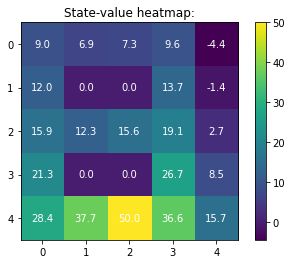

In [25]:
pi_agent.print_table()

In [26]:
type(pi_agent)

__main__.PolicyItertaionTrainer

### Section 2.2: Value Iteration

Recall the idea of value iteration. We update the state value: 

$$v_{k+1}(s) = \max_a E_{s'} [r(s, a) + \gamma v_{k}(s')]$$

wherein the $s'$ is next state, $r$ is the reward, $v_{k}(s')$ is the next state value given by the old (not updated yet) value function. The expectation is computed among all possible transitions (given a state and action pair, it is possible to have many different next states, since the environment is not deterministic).

The value iteration algorithm does not require an inner loop. It computes the expected return of all possible actions at a given state and uses the maximum of them as the state value. You can imagine it "pretends" we already have the optimal policy and run policy iteration based on it. Therefore we do not need to maintain a policy object in a trainer. We only need to retrieve the optimal policy using the same rule as policy iteration, given current value function.


In [27]:
class ValueIterationTrainer(PolicyItertaionTrainer):
    """Note that we inherate Policy Iteration Trainer, to resue the
    code of update_policy(). It's same since it get optimal policy from
    current state-value table (self.table).
    """

    def __init__(self, gamma=1.0):
        super(ValueIterationTrainer, self).__init__(gamma, None)

    def train(self):
        """Conduct one iteration of learning."""

        # In value iteration, we do not explicit require a
        # policy instance to run. We update value function
        # directly based on the transitions. Therefore, we
        # don't need to run self.update_policy() in each step.
        self.update_value_function()

    def update_value_function(self):
        old_table = self.table.copy()

        for state in range(self.obs_dim):
            state_value = 0

            # [TODO] what should be de right state value?
            # hint: try to compute the state_action_values first
            state_action_values = [0] * self.action_dim
            for act in range(self.action_dim):
                state_action_value = 0
                transitions_list = self._get_transitions(state,act)
                for transition in transitions_list:
                    prob = transition['prob']
                    reward = transition['reward']
                    next_state = transition['next_state']
                    state_action_value += prob*(reward+self.gamma*old_table[next_state])
                state_action_values[act] = state_action_value
            state_value = np.amax(np.asarray(state_action_values))

            self.table[state] = state_value

        # Till now the one step value update is finished.
        # You can see that we do not use a inner loop to update
        # the value function like what we did in policy iteration.
        # This is because to compute the state value, which is
        # a expectation among all possible action given by a
        # specified policy, we **pretend** already own the optimal
        # policy (the max operation).



In [28]:
# Solve the TODOs and remove `pass`

# Managing configurations of your experiments is important for your research.
default_vi_config = dict(
    max_iteration=10000,
    evaluate_interval=100,  # don't need to update policy each iteration
    gamma=0.8,
    eps=1e-10
)


def value_iteration(train_config=None):
    config = default_vi_config.copy()
    if train_config is not None:
        config.update(train_config)

    # [TODO] initialize Value Iteration Trainer. Remember to pass
    #  config['gamma'] to it.
    trainer = ValueIterationTrainer(gamma=config['gamma'])

    old_state_value_table = trainer.table.copy()
    # Txj
    trainer.update_policy()
    old_policy_result = {
        obs: -1 for obs in range(trainer.obs_dim)
    }

    for i in range(config['max_iteration']):
        # train the agent
        trainer.train()  # [TODO] please uncomment this line

        # evaluate the result
        if i % config['evaluate_interval'] == 0:
            print("[INFO]\tIn {} iteration.".format(
                i
            ))

            # [TODO] compare the new policy with old policy to check should
            #  we stop.
            # [HINT] If new and old policy have same output given any
            #  observation, them we consider the algorithm is converged and
            #  should be stopped.

            # Txj
            trainer.update_policy()
            new_policy_result = {
                obs: trainer.policy(obs) for obs in range(trainer.obs_dim)
            }

            should_stop = old_policy_result == new_policy_result
            
            if should_stop:
                print("We found policy is not changed anymore at "
                      "itertaion {}.".format(i))
                break
            old_policy_result = new_policy_result
       
            if i > 3000:
                print("You sure your codes is OK? It shouldn't take so many "
                      "({}) iterations to train a policy iteration "
                      "agent.".format(
                    i))

    return trainer


In [29]:
# Run this cell without modification

vi_agent = value_iteration()

[INFO]	In 0 iteration.
[INFO]	In 100 iteration.
[INFO]	In 200 iteration.
We found policy is not changed anymore at itertaion 200.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


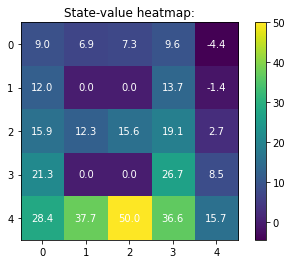

In [30]:
import matplotlib.pyplot as plt

harvest = vi_agent.table.reshape((5,5))
harvest1 = np.around(harvest,1)

fig, ax = plt.subplots()
# Plot the heatmap.
im = ax.imshow(harvest, interpolation="nearest")

# Create colorbar.
fig.colorbar(im, ax=ax)

# Loop over data dimensions and create text annotations.
for i in range(5):
    for j in range(5):
        text = ax.text(j, i, harvest1[i, j],
                       ha="center", va="center", color="w")

ax.set_title("State-value heatmap:")
plt.show()